In [2]:
# Load getdist and plot chains from Cobaya output
from getdist import MCSamples, plots, loadMCSamples
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb

complexity = 6
# Use a predefined runname from the ESR library that includes sine functions
runname = "core_maths"
potential_function_index = 35  # Index of the ESR function to use
chain_root = f'./chains/camb_esr/{runname}/compl_{complexity}/{potential_function_index}/results'

samples_tab = loadMCSamples(chain_root,settings={'ignore_rows': 0.33})

print('Parameter names available:', samples_tab.getParamNames().list())
# print('Parameter names available:', samples_direct.getParamNames().list())


./chains/camb_esr/core_maths/compl_6/35/results.1.txt
Removed 0.33 as burn in
Parameter names available: ['omch2', 'ombh2', 'H0', 'a1', 'a0', 'chi2__BAO', 'chi2__CMB', 'chi2__SN', 'chi2_total', 'omegam', 'rdrag', 'hrd', 'thetastar', 'chi2', 'chi2__cmb_lite_3d', 'chi2__bao.desi_dr2.desi_bao_all', 'chi2__sn.union3']


Saving triangle plot to mcmc_triangle.pdf
\Omega_\mathrm{b} h^2 = 0.02241^{+0.00020}_{-0.00022}
\Omega_\mathrm{c} h^2 = 0.1171^{+0.0011}_{-0.0016}
H_0 = 67.19^{+0.98}_{-0.75}
a0 = ---
a1 = 0.66^{+0.32}_{-0.47}


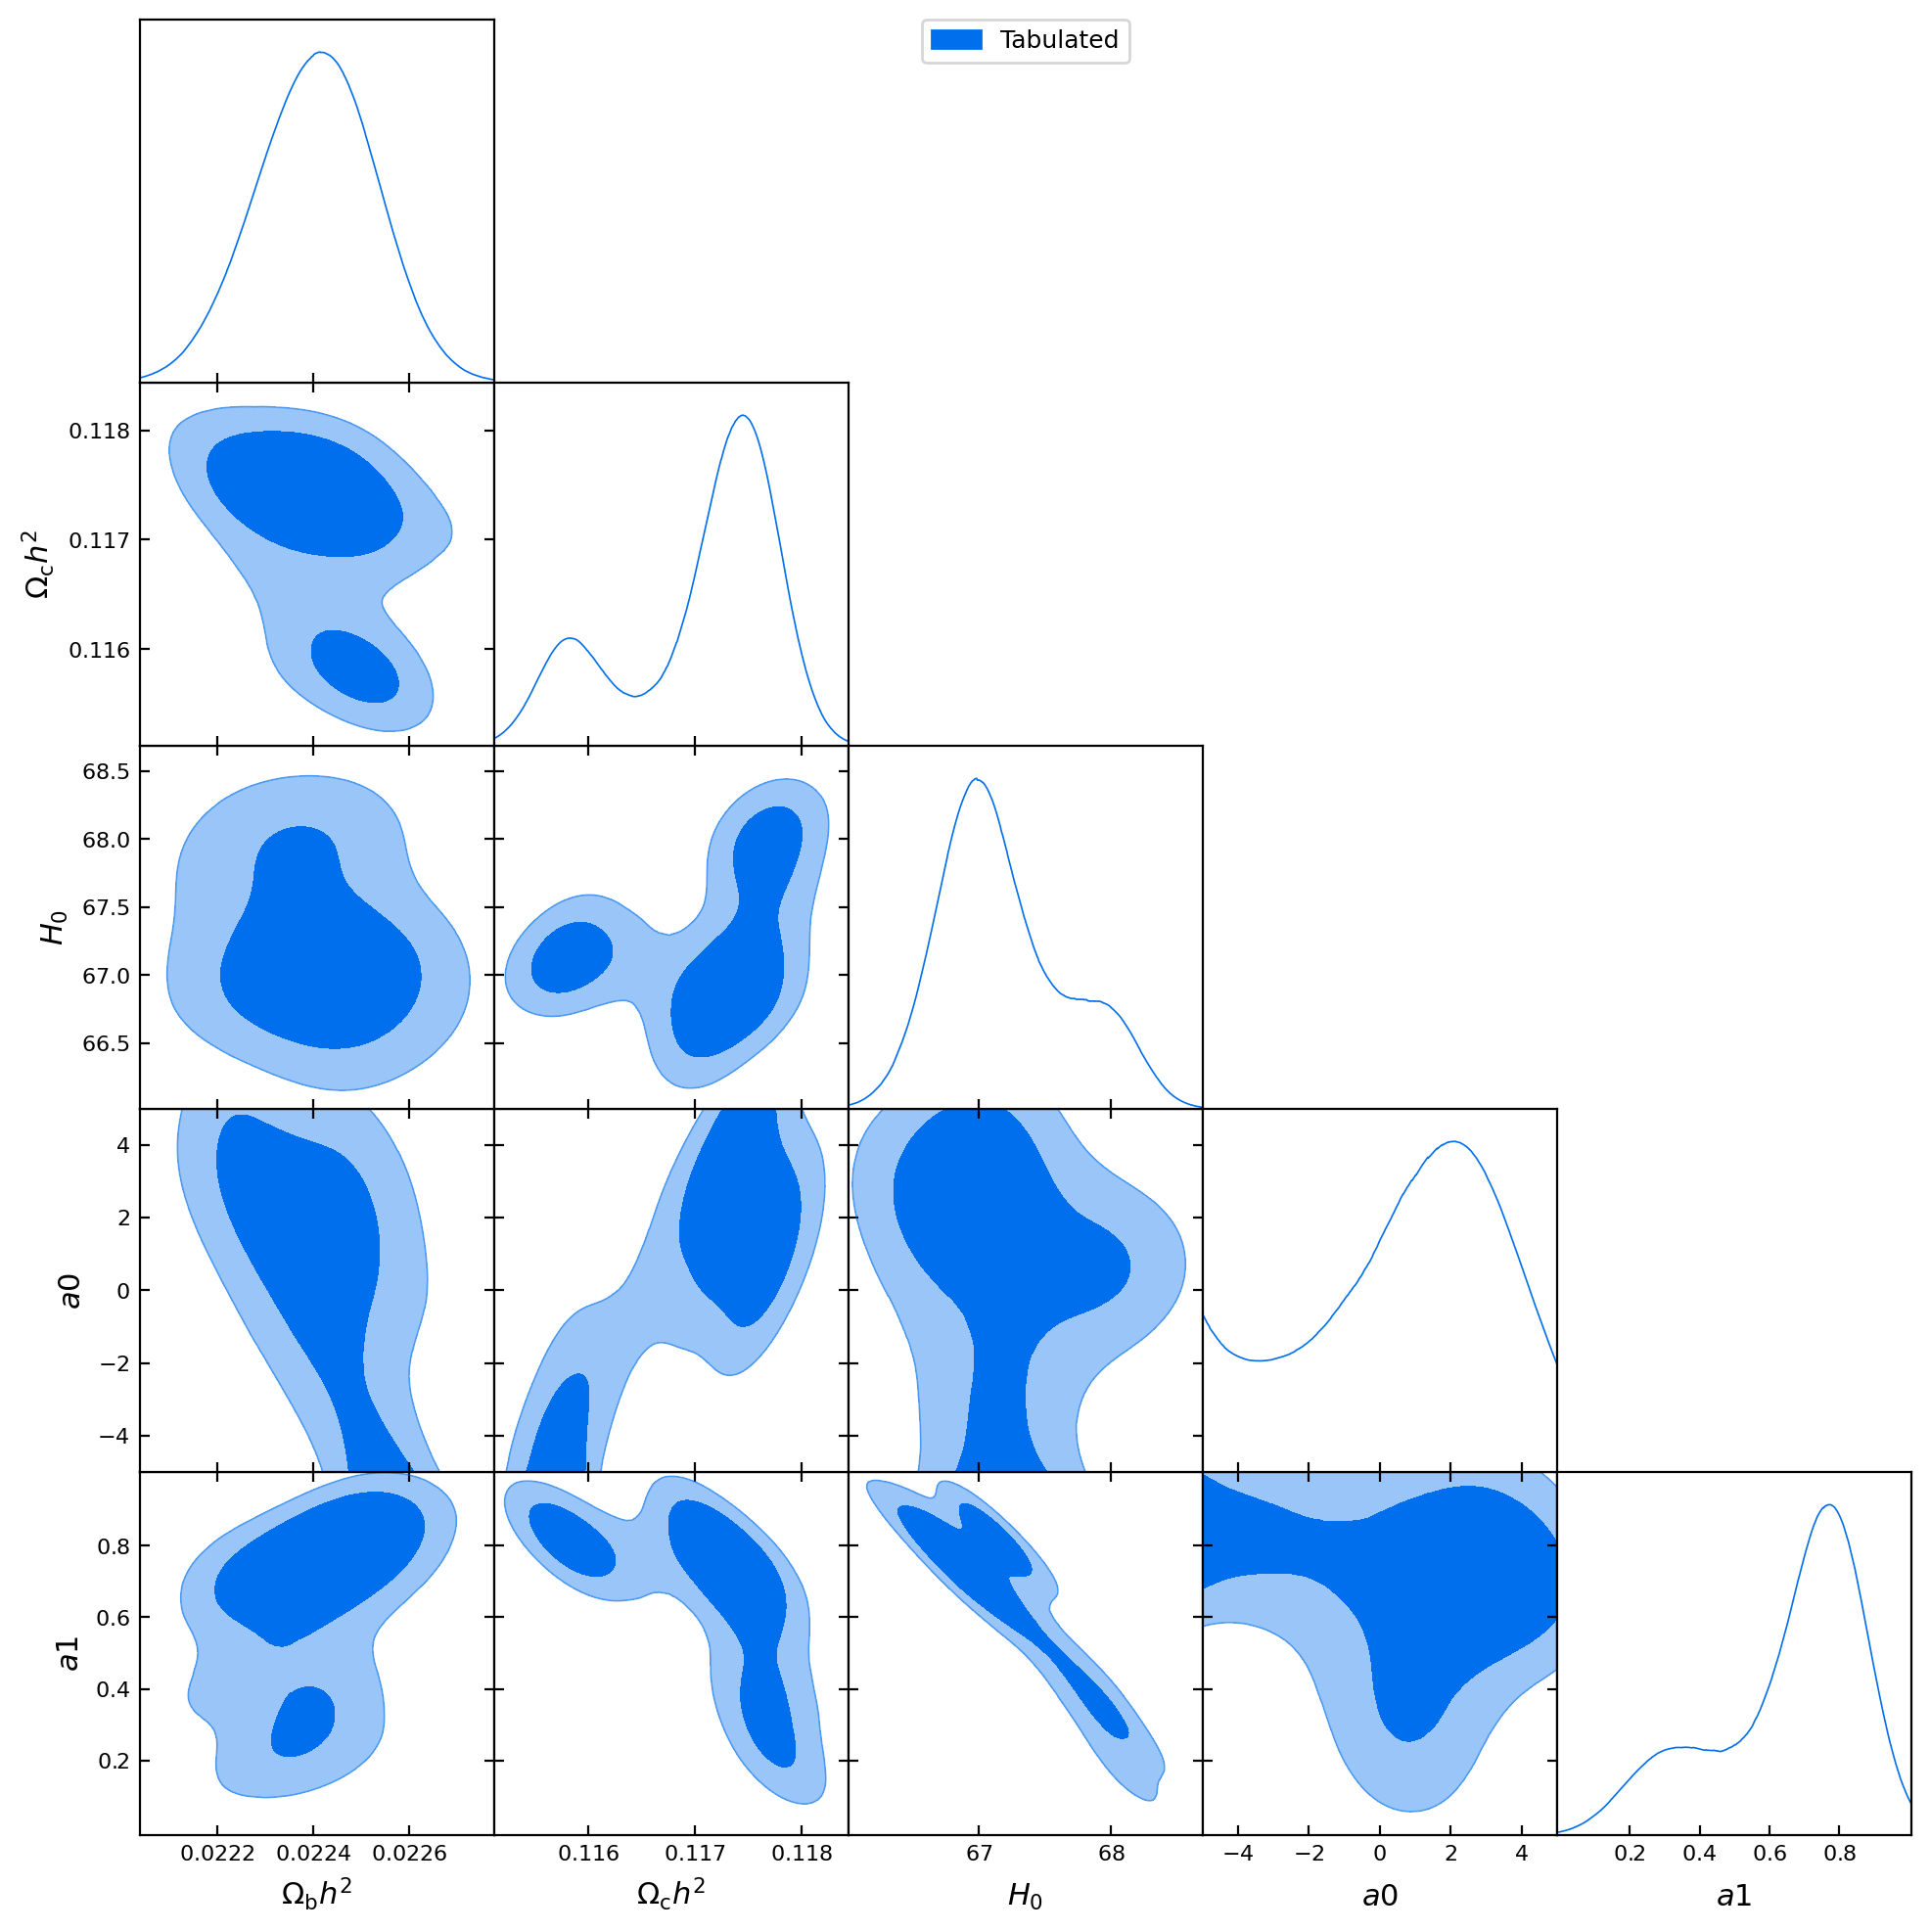

In [3]:
param_names = ['ombh2', 'omch2', 'H0','a0','a1']

g = plots.getSubplotPlotter()
g.triangle_plot([samples_tab], param_names, filled=True,legend_labels=['Tabulated', 'Direct']) #,param_limits=param_limits)
out_triangle = 'mcmc_triangle.pdf'
print('Saving triangle plot to', out_triangle)
# g.export(out_triangle)


for p in param_names:
    print(samples_tab.getInlineLatex(p,limit=2))

# # 1D marginals for each parameter separately
# for pname in samples.getParamNames().list():
#     name = pname.name
#     g = plots.getSinglePlotter()
#     g.plot_1d(samples, [name])
#     out1d = f'mcmc_1d_{name}.png'
#     print('Saving 1D marginal to', out1d)
#     g.export(out1d)


In [5]:
# Plot the potential

from CambESRPotential.esr_utils import load_esr_function_string, create_potential_table
esr_functions_file = f'./CambPotential/esrfunctions/{runname}/compl_{complexity}/unique_equations_{complexity}.txt'
esr_function_string, esr_function_template, esr_param_symbols = load_esr_function_string(esr_functions_file, potential_function_index)
esr_param_names = [str(p) for p in esr_param_symbols]

print('ESR function:', esr_function_string)


ESR function: a1*(a0 - x)


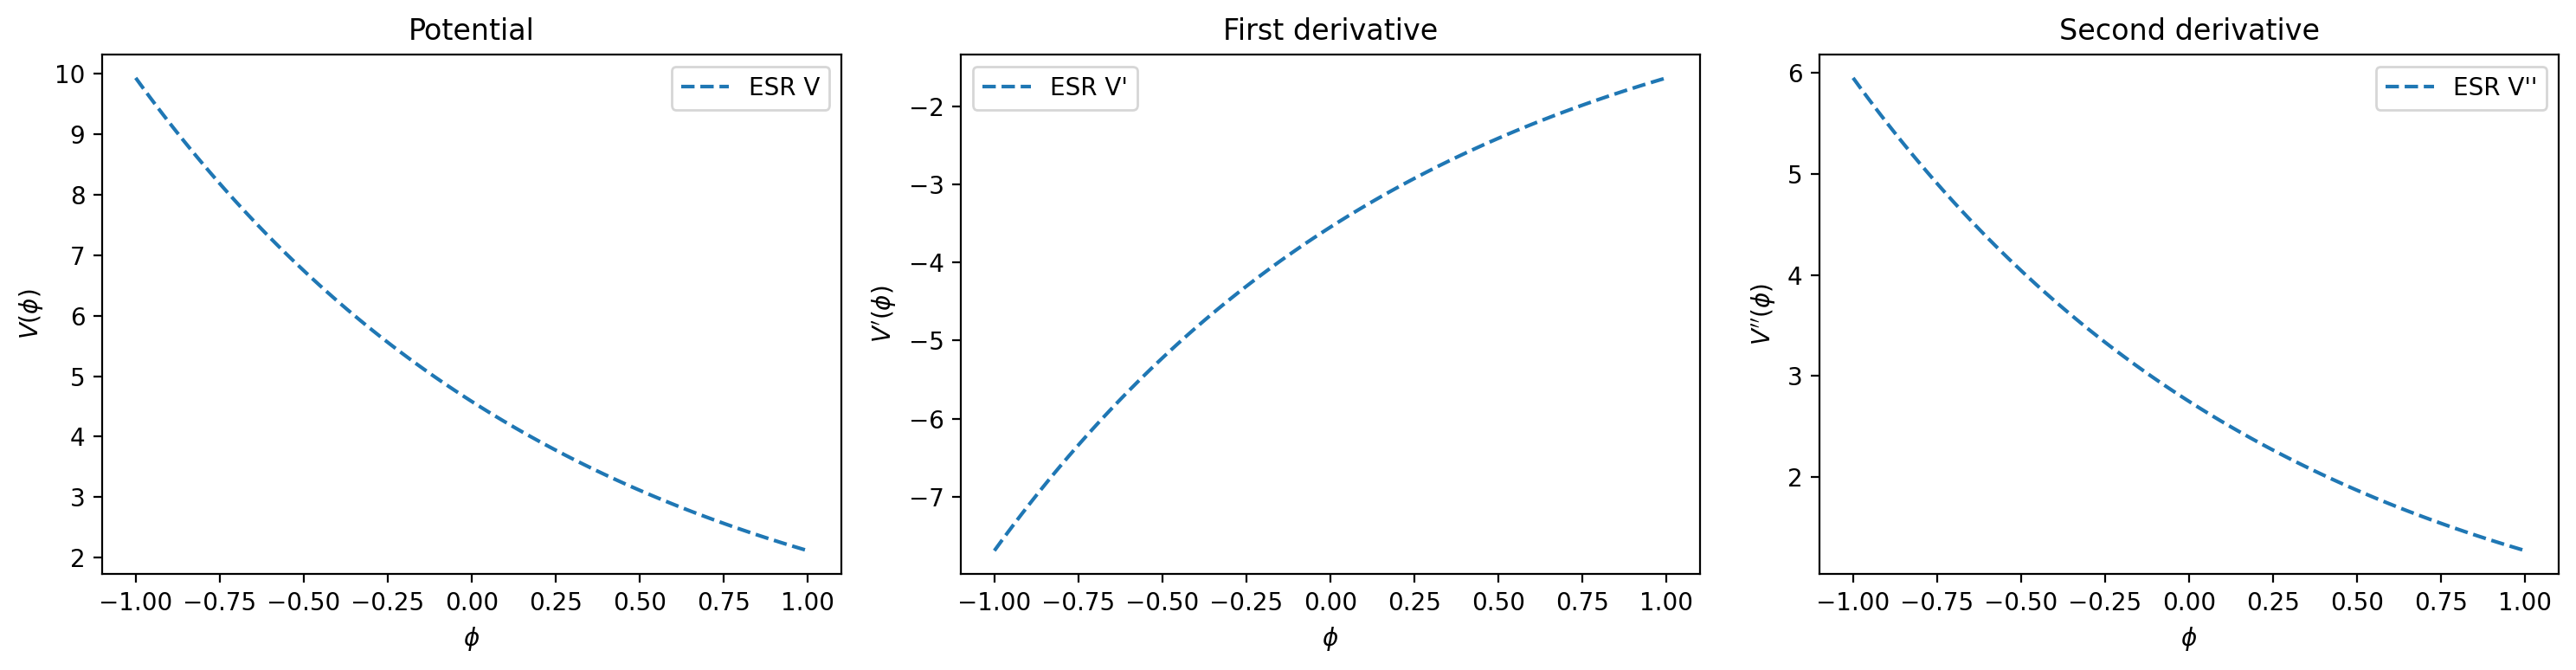

In [7]:
phi_vals = np.linspace(-1, 1, 100)
# # Analytic
# potential_vals = np.exp(-phi_vals**2)
# potential1_vals = -2 * phi_vals * np.exp(-phi_vals**2)
# potential2_vals = (4 * phi_vals**2 - 2) * np.exp(-phi_vals**2)

# ESR
esr_results_dict = create_potential_table(esr_function_template, esr_param_symbols, [1.966, 0.7741], phi_vals)
potential_vals_esr = esr_results_dict['V_train']
potential1_vals_esr = esr_results_dict['dV_train']
potential2_vals_esr = esr_results_dict['ddV_train']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# axes[0].plot(phi_vals, potential_vals, label='Analytic V')
axes[0].plot(phi_vals, potential_vals_esr, label='ESR V', linestyle='--')
axes[0].set_xlabel(r'$\phi$')
axes[0].set_ylabel(r'$V(\phi)$')
axes[0].set_title('Potential')
axes[0].legend()

# axes[1].plot(phi_vals, potential1_vals, label="Analytic V'")
axes[1].plot(phi_vals, potential1_vals_esr, label="ESR V'", linestyle='--')
axes[1].set_xlabel(r'$\phi$')
axes[1].set_ylabel(r"$V'(\phi)$")
axes[1].set_title("First derivative")
axes[1].legend()

# axes[2].plot(phi_vals, potential2_vals, label="Analytic V''")
axes[2].plot(phi_vals, potential2_vals_esr, label="ESR V''", linestyle='--')
axes[2].set_xlabel(r'$\phi$')
axes[2].set_ylabel(r"$V''(\phi)$")
axes[2].set_title("Second derivative")
axes[2].legend()

plt.tight_layout()
plt.show()

In [8]:
# Plot cosmology for the best-fit parameters
import pandas as pd

# best fit file
bestfit_file = chain_root + '.minimum.txt'
# --- Load the numerical results ---
data = pd.read_csv(bestfit_file, sep=r'\s+', comment='#',
                    header=None, engine='python')
with open(bestfit_file, 'r') as f:
                    header_line = f.readline().strip()
                    column_names = header_line.replace('#', '').strip().split()
data.columns = column_names
# print(column_names)

param_vals = data.iloc[0].to_dict()
cosmo_params = ['H0', 'ombh2', 'omch2']
cosmo_dict = {k: param_vals[k] for k in cosmo_params}
print('Best-fit parameters:', cosmo_dict)

Best-fit parameters: {'H0': 66.908502, 'ombh2': 0.022434045, 'omch2': 0.11697154}


In [9]:
esr_params = [param_vals[name] for name in esr_param_names]
print('ESR parameters:', dict(zip(esr_param_names, esr_params)))
potential_dict = create_potential_table(esr_function_template, 
                                        esr_param_symbols,
                                        esr_params, phi_vals)
phi_train = potential_dict['phi_train']
V_train = potential_dict['V_train']
dV_train = potential_dict['dV_train']
ddV_train = potential_dict['ddV_train']

pars = camb.set_params(**cosmo_dict,
    dark_energy_model='QuintessenceInterp', V_train=V_train,
    dV_train=dV_train, ddV_train=ddV_train, phi_train=phi_train)

# 3. Perform the CAMB calculation
results = camb.get_background(pars)


ESR parameters: {'a0': 1.9657891, 'a1': 0.77405254}


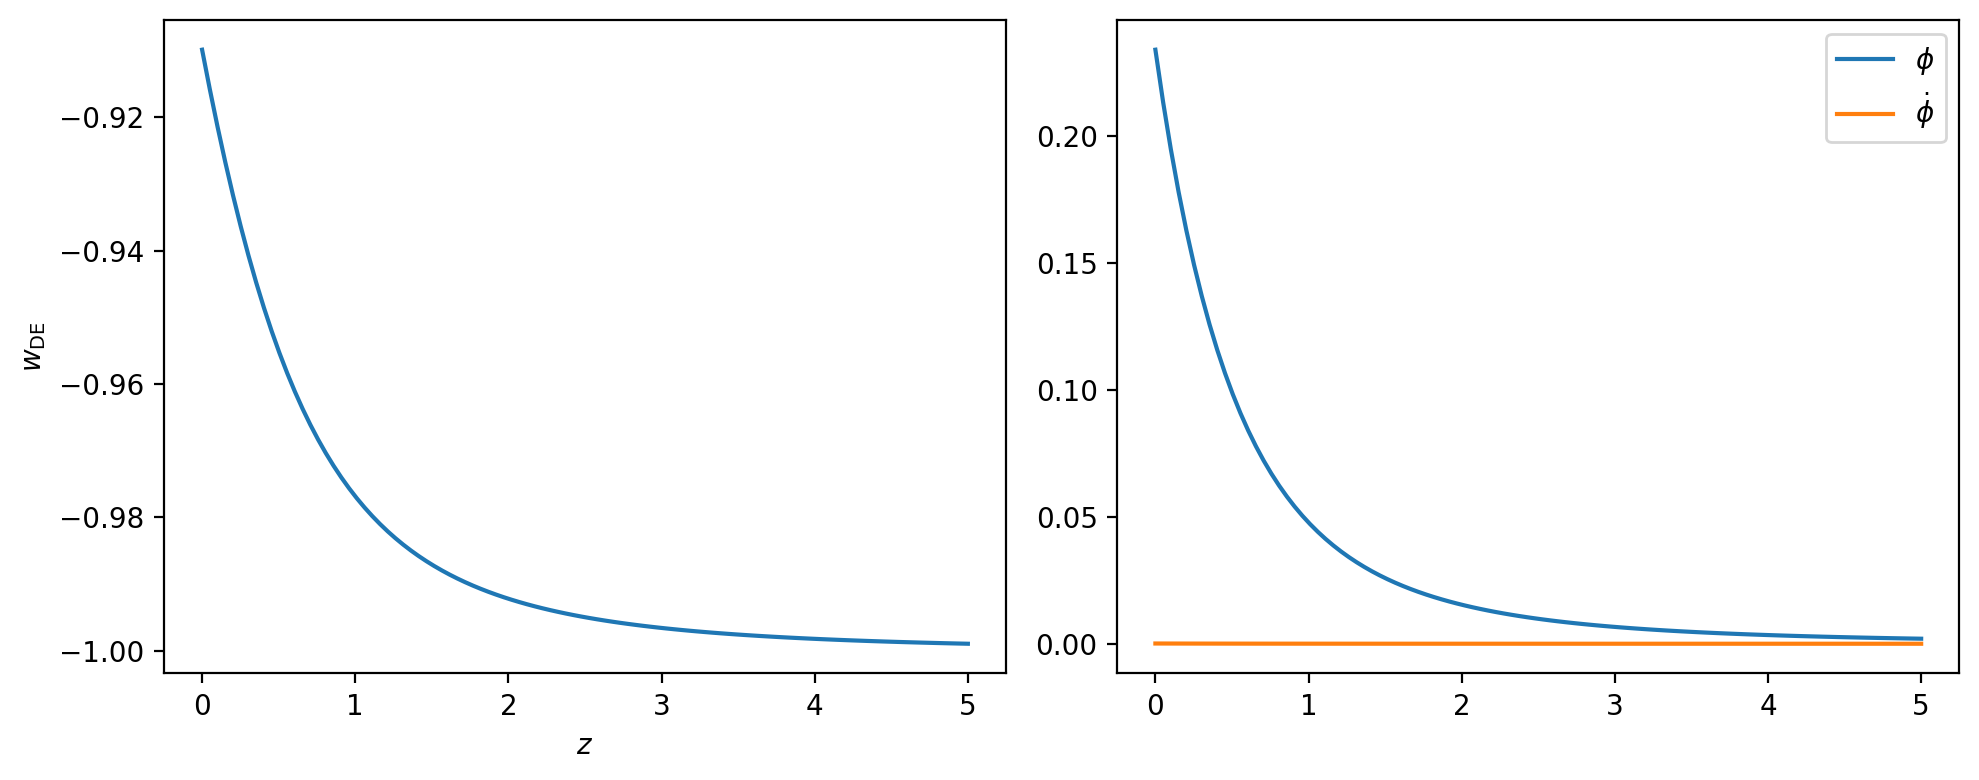

In [10]:
# plot DE eos 
z_arr = np.linspace(0, 5, 100)
_, wde = np.array(results.get_dark_energy_rho_w(1/(1+z_arr)))

phi, phidot = results.get_dark_energy_phi_phidot(1/(1+z_arr))

fig, ax = plt.subplots(1,2,figsize=(10,4)   )
ax[0].plot(z_arr, wde)
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$w_{\mathrm{DE}}$')

ax[1].plot(z_arr, phi, label=r'$\phi$')
ax[1].plot(z_arr, phidot, label=r'$\dot{\phi}$')
ax[1].legend()

plt.tight_layout()
